In [19]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms, datasets
from PIL import Image
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt

DATA_DIR = "/kaggle/input/wikiart" 
CKPT_PATH ="/kaggle/input/my-saved-model/efficientnet_b0_best.pth" 

selected_classes = ["Impressionism", "Realism", "Expressionism", "Romanticism", "Post_Impressionism"]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [20]:
# 2(Top 2 per Style)
from collections import defaultdict, Counter

print("Preparing Data & Extracting Artist Names...")

base_transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

full_dataset = datasets.ImageFolder(DATA_DIR)

class_to_idx_manual = {cls_name: i for i, cls_name in enumerate(selected_classes)}
print(f"Forced Style Mapping: {class_to_idx_manual}") 

all_data = []

for path, _ in full_dataset.samples:
    parent_folder = os.path.basename(os.path.dirname(path))
    
    if parent_folder in class_to_idx_manual:
        filename = os.path.basename(path)
        artist_name = filename.split('_')[0]
        
        correct_style_label = class_to_idx_manual[parent_folder]
        
        all_data.append((path, correct_style_label, artist_name))

style_to_artists = defaultdict(list)

for path, style_idx, artist_name in all_data:
    style_name = selected_classes[style_idx]
    style_to_artists[style_name].append(artist_name)

selected_top_artists = []
print("\nSelecting Top 2 Artists from each Style:")

for style_name in selected_classes:
    artists_in_style = style_to_artists[style_name]
    top_2 = Counter(artists_in_style).most_common(2)
    print(f" - {style_name}: {[x[0] for x in top_2]}")
    
    for artist, count in top_2:
        selected_top_artists.append(artist)

top_artists_names = list(set(selected_top_artists))

final_samples = []
final_artists_list = []

for path, style, artist in all_data:
    if artist in top_artists_names:
        final_samples.append((path, style, artist))
        final_artists_list.append(artist)

artist_encoder = LabelEncoder()
encoded_artists = artist_encoder.fit_transform(final_artists_list)
NUM_ARTISTS = len(artist_encoder.classes_)
NUM_STYLES = len(selected_classes)

print(f"\nFinal Dataset: {len(final_samples)} images covering {NUM_ARTISTS} Artists and {NUM_STYLES} Styles.")

Preparing Data & Extracting Artist Names...
✅ Forced Style Mapping: {'Impressionism': 0, 'Realism': 1, 'Expressionism': 2, 'Romanticism': 3, 'Post_Impressionism': 4}

Selecting Top 2 Artists from each Style:
 - Impressionism: ['pierre-auguste-renoir', 'claude-monet']
 - Realism: ['vincent-van-gogh', 'ilya-repin']
 - Expressionism: ['ernst-ludwig-kirchner', 'amedeo-modigliani']
 - Romanticism: ['gustave-dore', 'ivan-aivazovsky']
 - Post_Impressionism: ['vincent-van-gogh', 'pyotr-konchalovsky']

Final Dataset: 8020 images covering 9 Artists and 5 Styles.


In [21]:
# 3. Dataset & DataLoader
class MultiTaskDataset(Dataset):
    def __init__(self, samples, artist_labels, transform=None):
        self.samples = samples # list of (path, style, artist_str)
        self.artist_labels = artist_labels # list of ints
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, style_label, _ = self.samples[idx]
        artist_label = self.artist_labels[idx]
        
        try:
            img = Image.open(path).convert("RGB")
        except:
            img = Image.new('RGB', (224, 224))
            
        if self.transform:
            img = self.transform(img)
            
        return img, style_label, artist_label

train_samples, val_samples, train_art_lbls, val_art_lbls = train_test_split(
    final_samples, encoded_artists, test_size=0.2, random_state=42, stratify=encoded_artists
)

# Transformations
train_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])
val_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

train_ds = MultiTaskDataset(train_samples, train_art_lbls, transform=train_tfms)
val_ds = MultiTaskDataset(val_samples, val_art_lbls, transform=val_tfms)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2)


In [ ]:
# 4. (Multi-Task Model)
class MultiTaskModel(nn.Module):
    def __init__(self, num_styles, num_artists, pretrained_path):
        super(MultiTaskModel, self).__init__()
        
        # 1. Base Model Structure
        self.base = models.efficientnet_b0(weights=None)
        self.base.classifier[1] = nn.Linear(1280, num_styles)
        
        # 2. Loading Weights 
        if os.path.exists(pretrained_path):
            print(f"Loading weights from {pretrained_path}...")
            try:
                state_dict = torch.load(pretrained_path, map_location=device)
                self.base.load_state_dict(state_dict)
                print(" Weights loaded successfully!")
            except Exception as e:
                print(f"Error loading weights: {e}")
        else:
            print(f"Warning: Path {pretrained_path} not found. Using random weights (Not recommended).")

        # 3. Separation 
        self.features = self.base.features  # Convolutional Layers
        self.avgpool = self.base.avgpool # from 3d tensors to 1d vector (the last layer)
        self.flatten = nn.Flatten() # flatten
        
        # Style Head
        self.style_head = self.base.classifier # hmlna el weights fo'
        
        # Artist Head 
        self.artist_head = nn.Sequential(
            nn.Dropout(p=0.2), # to decrease overfitting
            nn.Linear(1280, num_artists) # convert 1280 to num artist
        )
    ####(forward method)=> how the data move into the network
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        
        style_out = self.style_head(x)
        artist_out = self.artist_head(x)
        return style_out, artist_out

model = MultiTaskModel(NUM_STYLES, NUM_ARTISTS, CKPT_PATH).to(device)


Loading weights from /kaggle/input/my-saved-model/efficientnet_b0_best.pth...
✅ Weights loaded successfully!


In [ ]:
# 5.(Training)

# Freeze Backbone & Style Head
for param in model.features.parameters():
    param.requires_grad = False
for param in model.style_head.parameters():
    param.requires_grad = False

print("Backbone and Style Head Frozen. Training ONLY Artist Head.")

# Optimizer (Notice we only optimize artist_head parameters)
optimizer = optim.Adam(model.artist_head.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

EPOCHS = 5 

print("\nStarting Training...")
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    correct_s, correct_a, total = 0, 0, 0
    
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    for imgs, s_lbl, a_lbl in loop:
        imgs, s_lbl, a_lbl = imgs.to(device), s_lbl.to(device), a_lbl.to(device)
        
        optimizer.zero_grad()
        
        # Forward
        s_pred, a_pred = model(imgs)
        
        # Loss (Only Artist Loss matters for optimization since Style is frozen)
        loss = criterion(a_pred, a_lbl)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # Metrics Calculation
        correct_s += (s_pred.argmax(1) == s_lbl).sum().item() # calculate style
        correct_a += (a_pred.argmax(1) == a_lbl).sum().item() # calculate artist
        total += imgs.size(0)
        
        loop.set_postfix(artist_loss=loss.item())
        
    print(f"Epoch {epoch+1}: Style Acc: {correct_s/total:.2%} (Fixed) | Artist Acc: {correct_a/total:.2%} (Learning)")


❄️ Backbone and Style Head Frozen. Training ONLY Artist Head.

Starting Training...


Epoch 1/5: 100%|██████████| 201/201 [01:49<00:00,  1.83it/s, artist_loss=0.519]


Epoch 1: Style Acc: 79.66% (Fixed) | Artist Acc: 80.80% (Learning)


Epoch 2/5: 100%|██████████| 201/201 [01:40<00:00,  2.01it/s, artist_loss=0.906]


Epoch 2: Style Acc: 80.25% (Fixed) | Artist Acc: 86.99% (Learning)


Epoch 3/5: 100%|██████████| 201/201 [01:40<00:00,  2.00it/s, artist_loss=0.464]


Epoch 3: Style Acc: 80.30% (Fixed) | Artist Acc: 87.76% (Learning)


Epoch 4/5: 100%|██████████| 201/201 [01:39<00:00,  2.02it/s, artist_loss=0.307] 


Epoch 4: Style Acc: 79.96% (Fixed) | Artist Acc: 88.47% (Learning)


Epoch 5/5: 100%|██████████| 201/201 [01:38<00:00,  2.03it/s, artist_loss=0.404] 

Epoch 5: Style Acc: 80.49% (Fixed) | Artist Acc: 88.87% (Learning)


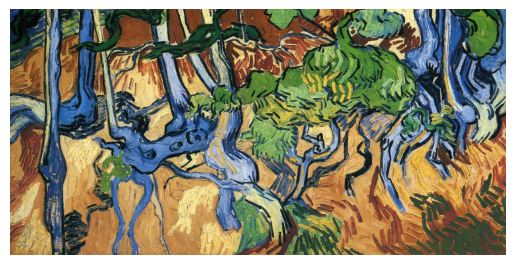

🖼️ Image: vincent-van-gogh_tree-roots-1890.jpg
Style:  Real (Post_Impressionism) | Pred (Post_Impressionism) ✅
Artist: Real (vincent-van-gogh) | Pred (vincent-van-gogh) ✅


In [ ]:
import random

# Inference / Testing Function

def predict_random_image():
    """
    Selects a random image from the validation set, runs it through the model,
    and visualizes the prediction results against the ground truth.
    """

    # --- 1. Data Selection ---
    # Pick a random index from the validation dataset
    random_idx = random.randint(0, len(val_samples) - 1) # choose random num 

    # Unpack the sample data: Image path, True Style Index (unused here), True Artist Name
    img_path, true_style_idx, true_artist_str = val_samples[random_idx]
    
    # Extract the true style name from the parent directory name (e.g., 'data/Impressionism/img.jpg')
    true_style_name = os.path.basename(os.path.dirname(img_path))
    
    # --- 2. Preprocessing ---
    # Set model to evaluation mode (disables Dropout, fixes Batch Norm)
    model.eval()

    # Load image and convert to RGB (to handle potential Grayscale images)
    img = Image.open(img_path).convert("RGB")
    tensor = val_tfms(img).unsqueeze(0).to(device)
    
    with torch.no_grad():
        s_out, a_out = model(tensor) # # Get raw logits for both heads
        s_prob = torch.softmax(s_out, 1) # Convert style logits to probabilities
        a_prob = torch.softmax(a_out, 1) # Convert artist logits to probabilities
    
    # Get the predicted style name using the index with the highest probability
    pred_style = selected_classes[s_prob.argmax().item()]

    # Get the predicted artist name by reversing the LabelEncoder (Index -> Name)
    pred_artist = artist_encoder.inverse_transform([a_prob.argmax().item()])[0]
    
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
    print(f"Image: {os.path.basename(img_path)}")
    
    is_style_correct = "✅" if pred_style == true_style_name else "❌"
    print(f"Style:  Real ({true_style_name}) | Pred ({pred_style}) {is_style_correct}")
    
    is_artist_correct = "✅" if pred_artist == true_artist_str else "❌"
    print(f"Artist: Real ({true_artist_str}) | Pred ({pred_artist}) {is_artist_correct}")

predict_random_image()